# Transformer
Le modèle NLP transformer, faisant référence spécifiquement aux modèles comme le Transformer original introduit dans l'article "Attention is All You Need" de Vaswani et al., est un type d'architecture de réseau neuronal qui a connu un grand succès dans des tâches telles que la traduction automatique.

Voici un aperçu de la façon dont un modèle transformer est entraîné pour la traduction automatique :

1. **Préparation des données** :
   - Rassemblez un grand ensemble de données de phrases parallèles dans les deux langues source et cible. Par exemple, si vous traduisez de l'anglais vers le français, vous aurez besoin d'un ensemble de données avec des phrases en anglais et leurs traductions correspondantes en français.

2. **Tokenisation** :
   - Divisez le texte en unités plus petites appelées tokens. En NLP, les tokens peuvent être des mots, des sous-mots (comme 'un-' et '-heureux' dans 'malheureux'), ou même des caractères.

3. **Incorporation** :
   - Convertissez les tokens en vecteurs numériques à l'aide d'une couche d'incorporation. Chaque token est représenté sous forme de vecteur de grande dimension.

4. **Encodage positionnel** :
   - Étant donné que les transformers n'ont pas de connaissance inhérente de l'ordre des tokens, des encodages positionnels sont ajoutés aux embeddings des tokens pour fournir des informations sur la position de chaque token dans une séquence.

5. **Architecture du modèle** :
   - Un transformer se compose d'un encodeur et d'un décodeur. L'encodeur et le décodeur ont tous deux plusieurs couches de mécanismes d'attention et de réseaux neuronaux feedforward.

6. **Encodeur** :
   - L'encodeur prend les tokens de la langue source en entrée et les traite à travers plusieurs couches d'auto-attention et de réseaux neuronaux feedforward. Cela permet au modèle d'apprendre des informations contextuelles à partir de l'entrée.

7. **Décodeur** :
   - Le décodeur a également plusieurs couches, mais il utilise en plus une attention sur la sortie de l'encodeur. Il prend la dernière couche de l'encodeur et ses propres prédictions précédentes en entrée.

8. **Objectif d'entraînement** :
   - L'objectif pendant l'entraînement est de minimiser la différence entre les phrases de langue cible prédites et les phrases de langue cible réelles.

9. **Fonction de perte** :
   - Une fonction de perte courante pour la traduction automatique est la perte de cross-entropie, qui mesure la dissimilarité entre les probabilités prédites (générées par le modèle) et les probabilités réelles (les vraies étiquettes cibles).

10. **Processus d'entraînement** :
    - Pendant l'entraînement, les paramètres (poids) du modèle sont mis à jour par rétropropagation et descente de gradient. Les gradients sont calculés par rapport à la fonction de perte, et les poids sont ajustés dans la direction qui minimise la perte.

11. **Entraînement en mini-lots** :
    - L'entraînement est généralement effectué en mini-lots, où un petit sous-ensemble des données est traité à la fois. Cela permet un calcul plus efficace et une meilleure utilisation des ressources.

12. **Validation et Test** :
    - La performance du modèle est évaluée sur un ensemble de validation distinct pour surveiller sa progression et éviter le surajustement. Une fois que le modèle est entraîné, il est évalué sur un ensemble de test qu'il n'a jamais vu auparavant.

13. **Inférence** :
    - Après l'entraînement, le modèle peut être utilisé pour la traduction. Lors de l'inférence, le modèle prend une phrase source, la traite à travers l'encodeur et génère la phrase cible correspondante en utilisant le décodeur.

Ce processus est répété sur plusieurs époques (passes à travers l'ensemble de données complet) jusqu'à ce que la performance du modèle sur l'ensemble de validation atteigne un plateau. Le modèle final entraîné peut ensuite être utilisé pour traduire de nouvelles phrases de la langue source vers la langue cible.

In [12]:
import os
import logging
import pickle
from tqdm.notebook import tqdm
from argparse import ArgumentParser
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import torchtext
from torchtext.data import BucketIterator
#from utils import CosineWithRestarts
from models import Transformer, create_masks
#from process_data import tokenize_data
import matplotlib.pyplot as plt

In [13]:
from tqdm import tqdm

In [14]:
def dum_tokenizer(sent):
    return sent.split()

In [15]:
batch_size=50

In [16]:
#Preparing dataloaders
FR = torchtext.data.Field(tokenize=dum_tokenizer, lower=True, init_token="<sos>", eos_token="<eos>",batch_first=True)
EN = torchtext.data.Field(tokenize=dum_tokenizer, lower=True, batch_first=True)

In [17]:
train_path = os.path.join("..","data", "df.csv")

In [18]:

train = torchtext.data.TabularDataset(train_path, format="csv", fields=[("EN", EN), ("FR", FR)])
FR.build_vocab(train)
EN.build_vocab(train)

train_iter = BucketIterator(train, batch_size=batch_size, repeat=False, sort_key=lambda x: (len(x["EN"]), len(x["FR"])),shuffle=True, train=True)
train_length = len(train)

In [19]:

src_vocab = len(EN.vocab)
trg_vocab = len(FR.vocab)
print(src_vocab," ",trg_vocab)

13211   22489


In [20]:
d_model=512
num_layers=6
n_heads=8

In [21]:
net = Transformer(src_vocab=src_vocab, trg_vocab=trg_vocab, d_model=d_model, num=num_layers, n_heads=n_heads).cuda()

In [22]:
criterion = nn.CrossEntropyLoss(reduction="mean", ignore_index=1)
optimizer = optim.Adam(net.parameters(), lr=0.00015, betas=(0.9, 0.98), eps=1e-9)

In [23]:
num_epochs=350
model_no=0

In [24]:
def evaluate(output, labels):
    ### ignore index 1 (padding) when calculating accuracy
    idxs = (labels != 1).nonzero().squeeze()
    o_labels = torch.softmax(output, dim=1).max(1)[1]
    if len(idxs) > 1:
        return (labels[idxs] == o_labels[idxs]).sum().item()/len(idxs)
    else:
        return (labels[idxs] == o_labels[idxs]).sum().item()



In [25]:
losses_per_epoch, accuracy_per_epoch = [],[]
for e in tqdm(range(num_epochs)):
        net.train()
        losses_per_batch = []; total_loss = 0.0
        for i, data in enumerate(train_iter):
            trg_input = data.FR[:,:-1]
            labels = data.FR[:,1:].contiguous().view(-1)
            src_mask, trg_mask = create_masks(data.EN, trg_input)

            data.EN = data.EN.cuda(); trg_input = trg_input.cuda(); labels = labels.cuda()
            src_mask = src_mask.cuda(); trg_mask = trg_mask.cuda()

            outputs = net(data.EN, trg_input, src_mask, trg_mask)
            outputs = outputs.view(-1, outputs.size(-1))
            loss = criterion(outputs, labels)

            loss.backward(); #break;break

            optimizer.step()
            optimizer.zero_grad()
            #scheduler.step()

            total_loss += loss.item()

            if i % 100 == 99: # print every 100 mini-batches of size = batch_size
                losses_per_batch.append(total_loss/100)
                total_loss = 0.0
        losses_per_epoch.append(sum(losses_per_batch)/len(losses_per_batch))

        acc = 0
        print("Évaluation...")
        with torch.no_grad():
            net.eval()
            for i, data in enumerate(train_iter):
                trg_input = data.FR[:,:-1]
                labels = data.FR[:,1:].contiguous().view(-1)
                src_mask, trg_mask = create_masks(data.EN, trg_input)

                data.EN = data.EN.cuda(); trg_input = trg_input.cuda(); labels = labels.cuda()
                src_mask = src_mask.cuda(); trg_mask = trg_mask.cuda()

                outputs = net(data.EN, trg_input, src_mask, trg_mask)
                outputs = outputs.view(-1, outputs.size(-1))

                acc += evaluate(outputs, labels)
        acc/=(i + 1)
        
        print("Pertes à Epoch %d: %.7f" % (e, losses_per_epoch[-1]))
        print("Précision à Epoch %d: %.7f" % (e, accuracy_per_epoch[-1]))
        if accuracy_per_epoch[-1] > acc:
            acc = accuracy_per_epoch[-1]
            torch.save({
                    'epoch': e + 1,\
                    'state_dict': net.state_dict(),\
                    'best_acc': acc,\
                    'optimizer' : optimizer.state_dict(),\
                }, os.path.join("..","data" ,"test_model_best_%d.pth.tar" % model_no))
        accuracy_per_epoch.append(acc)





  0%|                                                                                          | 0/350 [00:00<?, ?it/s]

Évaluation...


  0%|▏                                                                             | 1/350 [10:24<60:30:05, 624.08s/it]

Pertes à Epoch 0: 3.8206594
Précision à Epoch 0: 0.3945095
Évaluation...


  1%|▍                                                                             | 2/350 [20:44<60:07:54, 622.05s/it]

Pertes à Epoch 1: 3.2964759
Précision à Epoch 1: 0.4198534
Évaluation...


  1%|▋                                                                             | 3/350 [31:05<59:54:54, 621.60s/it]

Pertes à Epoch 2: 3.1319003
Précision à Epoch 2: 0.4364031
Évaluation...


  1%|▉                                                                             | 4/350 [41:28<59:46:12, 621.89s/it]

Pertes à Epoch 3: 3.0234483
Précision à Epoch 3: 0.4494165
Évaluation...


  1%|█                                                                             | 5/350 [51:53<59:42:42, 623.08s/it]

Pertes à Epoch 4: 2.9359329
Précision à Epoch 4: 0.4603404
Évaluation...


  2%|█▎                                                                          | 6/350 [1:02:23<59:45:16, 625.34s/it]

Pertes à Epoch 5: 2.8616603
Précision à Epoch 5: 0.4716270
Évaluation...


  2%|█▌                                                                          | 7/350 [1:12:50<59:39:06, 626.08s/it]

Pertes à Epoch 6: 2.7920853
Précision à Epoch 6: 0.4813081
Évaluation...


  2%|█▋                                                                          | 8/350 [1:23:20<59:34:39, 627.13s/it]

Pertes à Epoch 7: 2.7360918
Précision à Epoch 7: 0.4908431
Évaluation...


  3%|█▉                                                                          | 9/350 [1:33:49<59:28:25, 627.87s/it]

Pertes à Epoch 8: 2.6831957
Précision à Epoch 8: 0.5009895
Évaluation...


  3%|██▏                                                                        | 10/350 [1:44:16<59:15:53, 627.51s/it]

Pertes à Epoch 9: 2.6274846
Précision à Epoch 9: 0.5102734
Évaluation...


  3%|██▎                                                                        | 11/350 [1:54:38<58:57:06, 626.04s/it]

Pertes à Epoch 10: 2.5827788
Précision à Epoch 10: 0.5182226
Évaluation...


  3%|██▌                                                                        | 12/350 [2:05:08<58:51:56, 626.97s/it]

Pertes à Epoch 11: 2.5374632
Précision à Epoch 11: 0.5295363
Évaluation...


  4%|██▊                                                                        | 13/350 [2:15:37<58:45:30, 627.69s/it]

Pertes à Epoch 12: 2.4972038
Précision à Epoch 12: 0.5352639
Évaluation...


  4%|███                                                                        | 14/350 [2:25:59<58:24:52, 625.87s/it]

Pertes à Epoch 13: 2.4616877
Précision à Epoch 13: 0.5453522
Évaluation...


  4%|███▏                                                                       | 15/350 [2:36:26<58:16:52, 626.31s/it]

Pertes à Epoch 14: 2.4420582
Précision à Epoch 14: 0.5511511
Évaluation...


  5%|███▍                                                                       | 16/350 [2:46:55<58:10:57, 627.12s/it]

Pertes à Epoch 15: 2.4360223
Précision à Epoch 15: 0.5570300
Évaluation...


  5%|███▋                                                                       | 17/350 [2:57:18<57:54:32, 626.04s/it]

Pertes à Epoch 16: 2.4143337
Précision à Epoch 16: 0.5645861
Évaluation...


  5%|███▊                                                                       | 18/350 [3:07:42<57:39:19, 625.18s/it]

Pertes à Epoch 17: 2.3947199
Précision à Epoch 17: 0.5712038
Évaluation...


  5%|████                                                                       | 19/350 [3:18:06<57:27:50, 624.99s/it]

Pertes à Epoch 18: 2.3629718
Précision à Epoch 18: 0.5777451
Évaluation...


  6%|████▎                                                                      | 20/350 [3:28:28<57:12:57, 624.17s/it]

Pertes à Epoch 19: 2.3507094
Précision à Epoch 19: 0.5831425
Évaluation...


  6%|████▌                                                                      | 21/350 [3:38:54<57:05:01, 624.62s/it]

Pertes à Epoch 20: 2.3285113
Précision à Epoch 20: 0.5868376
Évaluation...


  6%|████▋                                                                      | 22/350 [3:49:19<56:55:28, 624.78s/it]

Pertes à Epoch 21: 2.3084944
Précision à Epoch 21: 0.5924410
Évaluation...


  7%|████▉                                                                      | 23/350 [3:59:41<56:40:41, 623.98s/it]

Pertes à Epoch 22: 2.2923410
Précision à Epoch 22: 0.5993819
Évaluation...


  7%|█████▏                                                                     | 24/350 [4:10:09<56:36:28, 625.12s/it]

Pertes à Epoch 23: 2.2683933
Précision à Epoch 23: 0.6021612
Évaluation...


  7%|█████▎                                                                     | 25/350 [4:20:33<56:23:28, 624.64s/it]

Pertes à Epoch 24: 2.2589241
Précision à Epoch 24: 0.6083096
Évaluation...


  7%|█████▌                                                                     | 26/350 [4:30:56<56:11:39, 624.38s/it]

Pertes à Epoch 25: 2.2429386
Précision à Epoch 25: 0.6132701
Évaluation...


  8%|█████▊                                                                     | 27/350 [4:41:23<56:05:18, 625.13s/it]

Pertes à Epoch 26: 2.2232203
Précision à Epoch 26: 0.6164969
Évaluation...


  8%|██████                                                                     | 28/350 [4:51:56<56:07:10, 627.42s/it]

Pertes à Epoch 27: 2.2233789
Précision à Epoch 27: 0.6220800
Évaluation...


  8%|██████▏                                                                    | 29/350 [5:02:21<55:52:06, 626.56s/it]

Pertes à Epoch 28: 2.2113213
Précision à Epoch 28: 0.6248520
Évaluation...


  9%|██████▍                                                                    | 30/350 [5:12:44<55:36:04, 625.51s/it]

Pertes à Epoch 29: 2.1906767
Précision à Epoch 29: 0.6296669
Évaluation...


  9%|██████▋                                                                    | 31/350 [5:23:08<55:23:06, 625.04s/it]

Pertes à Epoch 30: 2.1741250
Précision à Epoch 30: 0.6320256
Évaluation...


  9%|██████▊                                                                    | 32/350 [5:33:43<55:28:48, 628.08s/it]

Pertes à Epoch 31: 2.1652879
Précision à Epoch 31: 0.6349274
Évaluation...


  9%|███████                                                                    | 33/350 [5:44:07<55:11:51, 626.85s/it]

Pertes à Epoch 32: 2.1545184
Précision à Epoch 32: 0.6401319
Évaluation...


 10%|███████▎                                                                   | 34/350 [5:54:32<54:58:24, 626.28s/it]

Pertes à Epoch 33: 2.1416482
Précision à Epoch 33: 0.6436909
Évaluation...


 10%|███████▌                                                                   | 35/350 [6:04:57<54:47:12, 626.14s/it]

Pertes à Epoch 34: 2.1314116
Précision à Epoch 34: 0.6440677
Évaluation...


 10%|███████▋                                                                   | 36/350 [6:15:16<54:24:39, 623.82s/it]

Pertes à Epoch 35: 2.1148635
Précision à Epoch 35: 0.6489121
Évaluation...


 11%|███████▉                                                                   | 37/350 [6:25:37<54:09:38, 622.94s/it]

Pertes à Epoch 36: 2.1110374
Précision à Epoch 36: 0.6518119
Évaluation...


 11%|████████▏                                                                  | 38/350 [6:36:08<54:12:20, 625.45s/it]

Pertes à Epoch 37: 2.0965797
Précision à Epoch 37: 0.6535692
Évaluation...


 11%|████████▎                                                                  | 39/350 [6:46:34<54:02:55, 625.65s/it]

Pertes à Epoch 38: 2.0957517
Précision à Epoch 38: 0.6566531
Évaluation...


 11%|████████▌                                                                  | 40/350 [6:56:53<53:42:16, 623.67s/it]

Pertes à Epoch 39: 2.0783713
Précision à Epoch 39: 0.6616908
Évaluation...


 12%|████████▊                                                                  | 41/350 [7:07:18<53:33:33, 623.99s/it]

Pertes à Epoch 40: 2.0732631
Précision à Epoch 40: 0.6616539
Évaluation...


 12%|█████████                                                                  | 42/350 [7:17:43<53:25:10, 624.39s/it]

Pertes à Epoch 41: 2.0673594
Précision à Epoch 41: 0.6640370
Évaluation...


 12%|█████████▏                                                                 | 43/350 [7:28:12<53:20:55, 625.59s/it]

Pertes à Epoch 42: 2.0494123
Précision à Epoch 42: 0.6633967
Évaluation...


 13%|█████████▍                                                                 | 44/350 [7:38:31<53:00:26, 623.61s/it]

Pertes à Epoch 43: 2.0481431
Précision à Epoch 43: 0.6682194
Évaluation...


 13%|█████████▋                                                                 | 45/350 [7:48:55<52:51:13, 623.85s/it]

Pertes à Epoch 44: 2.0394028
Précision à Epoch 44: 0.6709833
Évaluation...


 13%|█████████▊                                                                 | 46/350 [7:59:20<52:42:49, 624.24s/it]

Pertes à Epoch 45: 2.0262124
Précision à Epoch 45: 0.6707885
Évaluation...


 13%|██████████                                                                 | 47/350 [8:09:48<52:37:21, 625.22s/it]

Pertes à Epoch 46: 2.0268024
Précision à Epoch 46: 0.6743784
Évaluation...


 14%|██████████▎                                                                | 48/350 [8:20:12<52:25:52, 625.01s/it]

Pertes à Epoch 47: 2.0196373
Précision à Epoch 47: 0.6778900
Évaluation...


 14%|██████████▌                                                                | 49/350 [8:30:37<52:15:10, 624.95s/it]

Pertes à Epoch 48: 2.0069301
Précision à Epoch 48: 0.6770554
Évaluation...


 14%|██████████▋                                                                | 50/350 [8:41:04<52:08:11, 625.64s/it]

Pertes à Epoch 49: 1.9870137
Précision à Epoch 49: 0.6780948
Évaluation...


 15%|██████████▉                                                                | 51/350 [8:51:28<51:55:13, 625.13s/it]

Pertes à Epoch 50: 1.9885951
Précision à Epoch 50: 0.6799309
Évaluation...


 15%|███████████▏                                                               | 52/350 [9:01:52<51:42:59, 624.76s/it]

Pertes à Epoch 51: 1.9753357
Précision à Epoch 51: 0.6843613
Évaluation...


 15%|███████████▎                                                               | 53/350 [9:12:09<51:20:51, 622.40s/it]

Pertes à Epoch 52: 1.9713367
Précision à Epoch 52: 0.6854424
Évaluation...


 15%|███████████▌                                                               | 54/350 [9:22:33<51:13:19, 622.97s/it]

Pertes à Epoch 53: 1.9571263
Précision à Epoch 53: 0.6891140
Évaluation...


 16%|███████████▊                                                               | 55/350 [9:32:53<50:57:30, 621.87s/it]

Pertes à Epoch 54: 1.9556179
Précision à Epoch 54: 0.6900456
Évaluation...


 16%|████████████                                                               | 56/350 [9:43:24<51:00:50, 624.66s/it]

Pertes à Epoch 55: 1.9507051
Précision à Epoch 55: 0.6887637
Évaluation...


 16%|████████████▏                                                              | 57/350 [9:53:46<50:46:34, 623.87s/it]

Pertes à Epoch 56: 1.9378738
Précision à Epoch 56: 0.6941771
Évaluation...


 17%|████████████▎                                                             | 58/350 [10:04:05<50:29:43, 622.55s/it]

Pertes à Epoch 57: 1.9304326
Précision à Epoch 57: 0.6935893
Évaluation...


 17%|████████████▍                                                             | 59/350 [10:14:31<50:24:26, 623.60s/it]

Pertes à Epoch 58: 1.9161113
Précision à Epoch 58: 0.6941537
Évaluation...


 17%|████████████▋                                                             | 60/350 [10:24:53<50:10:47, 622.92s/it]

Pertes à Epoch 59: 1.9052559
Précision à Epoch 59: 0.6963786
Évaluation...


 17%|████████████▉                                                             | 61/350 [10:35:21<50:07:56, 624.49s/it]

Pertes à Epoch 60: 1.9030119
Précision à Epoch 60: 0.6973466
Évaluation...


 18%|█████████████                                                             | 62/350 [10:45:50<50:04:16, 625.89s/it]

Pertes à Epoch 61: 1.8930212
Précision à Epoch 61: 0.6987292
Évaluation...


 18%|█████████████▎                                                            | 63/350 [10:56:17<49:55:49, 626.31s/it]

Pertes à Epoch 62: 1.8814030
Précision à Epoch 62: 0.7001910
Évaluation...


 18%|█████████████▌                                                            | 64/350 [11:06:43<49:44:59, 626.22s/it]

Pertes à Epoch 63: 1.8812937
Précision à Epoch 63: 0.7024375
Évaluation...


 19%|█████████████▋                                                            | 65/350 [11:17:10<49:35:21, 626.39s/it]

Pertes à Epoch 64: 1.8756519
Précision à Epoch 64: 0.7057073
Évaluation...


 19%|█████████████▉                                                            | 66/350 [11:27:32<49:19:12, 625.18s/it]

Pertes à Epoch 65: 1.8637754
Précision à Epoch 65: 0.7035748
Évaluation...


 19%|██████████████▏                                                           | 67/350 [11:37:54<49:03:18, 624.02s/it]

Pertes à Epoch 66: 1.8597569
Précision à Epoch 66: 0.7067391
Évaluation...


 19%|██████████████▍                                                           | 68/350 [11:48:16<48:50:21, 623.48s/it]

Pertes à Epoch 67: 1.8476313
Précision à Epoch 67: 0.7082676
Évaluation...


 20%|██████████████▌                                                           | 69/350 [11:58:46<48:49:06, 625.43s/it]

Pertes à Epoch 68: 1.8421406
Précision à Epoch 68: 0.7090799
Évaluation...


 20%|██████████████▊                                                           | 70/350 [12:09:09<48:34:46, 624.59s/it]

Pertes à Epoch 69: 1.8331028
Précision à Epoch 69: 0.7085909
Évaluation...


 20%|███████████████                                                           | 71/350 [12:19:38<48:31:39, 626.16s/it]

Pertes à Epoch 70: 1.8360097
Précision à Epoch 70: 0.7118905
Évaluation...


 21%|███████████████▏                                                          | 72/350 [12:30:04<48:20:10, 625.94s/it]

Pertes à Epoch 71: 1.8183103
Précision à Epoch 71: 0.7140338
Évaluation...


 21%|███████████████▍                                                          | 73/350 [12:40:28<48:06:59, 625.34s/it]

Pertes à Epoch 72: 1.8099957
Précision à Epoch 72: 0.7133796
Évaluation...


 21%|███████████████▋                                                          | 74/350 [12:50:48<47:49:14, 623.75s/it]

Pertes à Epoch 73: 1.8045846
Précision à Epoch 73: 0.7162536
Évaluation...


 21%|███████████████▊                                                          | 75/350 [13:01:13<47:40:14, 624.05s/it]

Pertes à Epoch 74: 1.7973756
Précision à Epoch 74: 0.7168378
Évaluation...


 22%|████████████████                                                          | 76/350 [13:11:39<47:32:38, 624.67s/it]

Pertes à Epoch 75: 1.7915535
Précision à Epoch 75: 0.7172028
Évaluation...


 22%|████████████████▎                                                         | 77/350 [13:22:08<47:28:03, 625.95s/it]

Pertes à Epoch 76: 1.7874101
Précision à Epoch 76: 0.7164369
Évaluation...


 22%|████████████████▍                                                         | 78/350 [13:32:33<47:16:56, 625.79s/it]

Pertes à Epoch 77: 1.7862307
Précision à Epoch 77: 0.7188706
Évaluation...


 23%|████████████████▋                                                         | 79/350 [13:42:56<47:02:45, 624.97s/it]

Pertes à Epoch 78: 1.7809292
Précision à Epoch 78: 0.7198959
Évaluation...


 23%|████████████████▉                                                         | 80/350 [13:53:17<46:46:32, 623.67s/it]

Pertes à Epoch 79: 1.7696670
Précision à Epoch 79: 0.7212367
Évaluation...


 23%|█████████████████▏                                                        | 81/350 [14:03:43<46:40:11, 624.58s/it]

Pertes à Epoch 80: 1.7620180
Précision à Epoch 80: 0.7214530
Évaluation...


 23%|█████████████████▎                                                        | 82/350 [14:14:11<46:33:04, 625.32s/it]

Pertes à Epoch 81: 1.7577539
Précision à Epoch 81: 0.7225156
Évaluation...


 24%|█████████████████▌                                                        | 83/350 [14:24:32<46:16:56, 624.03s/it]

Pertes à Epoch 82: 1.7562365
Précision à Epoch 82: 0.7250949
Évaluation...


 24%|█████████████████▊                                                        | 84/350 [14:34:50<45:59:23, 622.42s/it]

Pertes à Epoch 83: 1.7524169
Précision à Epoch 83: 0.7258608
Évaluation...


 24%|█████████████████▉                                                        | 85/350 [14:45:18<45:55:50, 623.96s/it]

Pertes à Epoch 84: 1.7503704
Précision à Epoch 84: 0.7261416
Évaluation...


 25%|██████████████████▏                                                       | 86/350 [14:55:44<45:47:54, 624.52s/it]

Pertes à Epoch 85: 1.7380136
Précision à Epoch 85: 0.7264068
Évaluation...


 25%|██████████████████▍                                                       | 87/350 [15:06:06<45:34:42, 623.89s/it]

Pertes à Epoch 86: 1.7305190
Précision à Epoch 86: 0.7272002
Évaluation...


 25%|██████████████████▌                                                       | 88/350 [15:16:28<45:21:35, 623.26s/it]

Pertes à Epoch 87: 1.7355700
Précision à Epoch 87: 0.7268490
Évaluation...


 25%|██████████████████▊                                                       | 89/350 [15:26:50<45:10:10, 623.03s/it]

Pertes à Epoch 88: 1.7288455
Précision à Epoch 88: 0.7281120
Évaluation...


 26%|███████████████████                                                       | 90/350 [15:37:03<44:46:58, 620.07s/it]

Pertes à Epoch 89: 1.7231756
Précision à Epoch 89: 0.7281805
Évaluation...


 26%|███████████████████▏                                                      | 91/350 [15:47:27<44:40:37, 620.99s/it]

Pertes à Epoch 90: 1.7131549
Précision à Epoch 90: 0.7311051
Évaluation...


 26%|███████████████████▍                                                      | 92/350 [15:57:52<44:36:12, 622.37s/it]

Pertes à Epoch 91: 1.7052336
Précision à Epoch 91: 0.7305860
Évaluation...


 27%|███████████████████▋                                                      | 93/350 [16:08:14<44:25:21, 622.26s/it]

Pertes à Epoch 92: 1.7040976
Précision à Epoch 92: 0.7313765
Évaluation...


 27%|███████████████████▊                                                      | 94/350 [16:18:42<44:21:27, 623.78s/it]

Pertes à Epoch 93: 1.7038012
Précision à Epoch 93: 0.7325832
Évaluation...


 27%|████████████████████                                                      | 95/350 [16:29:06<44:11:37, 623.91s/it]

Pertes à Epoch 94: 1.6961982
Précision à Epoch 94: 0.7341146
Évaluation...


 27%|████████████████████                                                      | 95/350 [16:39:02<44:41:37, 630.97s/it]


KeyboardInterrupt: 

Formation terminée


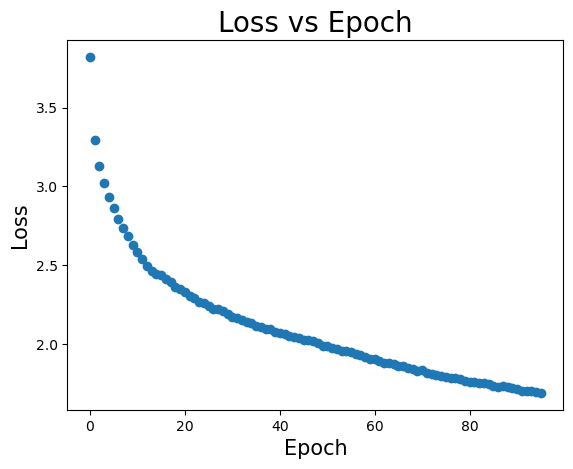

In [26]:
print("Formation terminée")
plt.scatter([i for i in range(len(losses_per_epoch))], losses_per_epoch)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.title("Loss vs Epoch", fontsize=20)
plt.savefig(os.path.join("..","data","test_loss_vs_epoch_%d.png" % model_no))



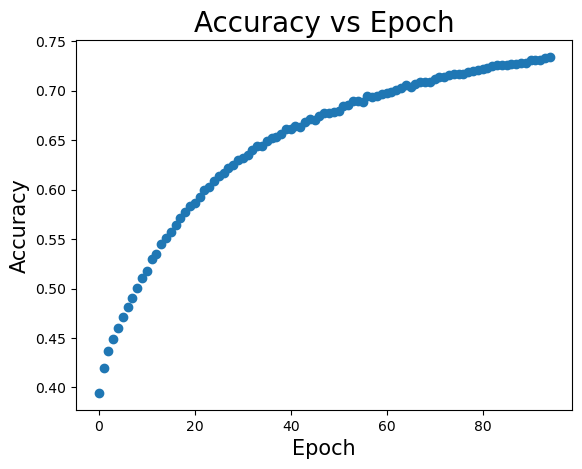

In [27]:

plt.scatter([i for i in range(len(accuracy_per_epoch))], accuracy_per_epoch)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.title("Accuracy vs Epoch", fontsize=20)
plt.savefig(os.path.join("..","data", "test_Accuracy_vs_epoch_%d.png" %model_no))